# Exercise 5 - R: Regularized Linear Regression and Bias vs. Variance

## *Part I*: Regularized Linear Regression

Predicting the amount of water flowing out of a dam using the change of water level in a reservoir

Part I is primarily setup for creating a regularized logistic regression model before diving into the new concepts for this exercise

---

Beginning with package imports, data loading, and initial visualization

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave  matrices
  library(repr)  # Resizing plot sizes in jupyter
  library(ggplot2)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles
options(repr.plot.width=7, repr.plot.height=4.5)  # Adjusts plot sizes

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'repr' was built under R version 3.3.3"

In [2]:
# Loading in the data from the .mat files
data <- readMat('ex5/ex5data1.mat')

# Unpacking values from the .mat file
# Training set for fitting the models
X <- data$X
y <- data$y

# Validation set for determining the regularization parameter
Xval <- data$Xval
yval <- data$yval

# Test set for evaluating performance
Xtest <- data$Xtest
ytest <- data$ytest

rm(data)  # Clearing data from environment

print(dim(X))

[1] 12  1


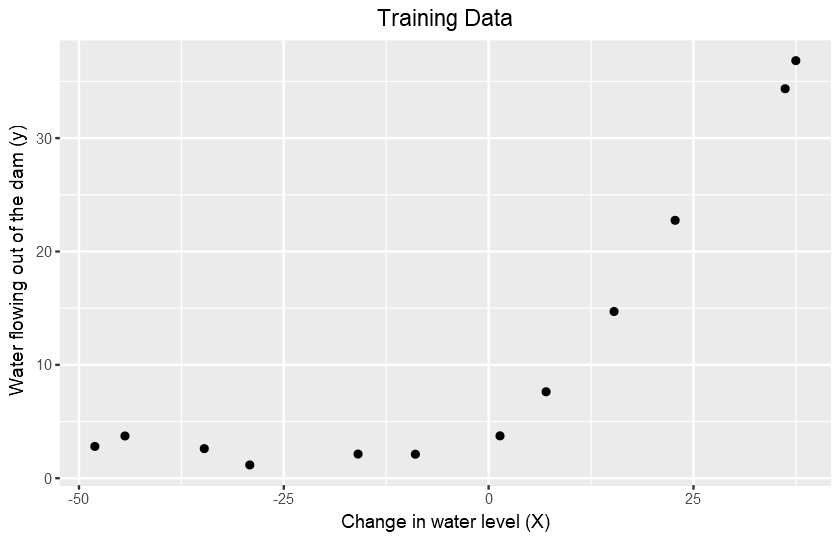

In [3]:
df <- data.frame(X, y)

ggplot(df) +
  geom_point(aes(X, y)) +
  labs(x="Change in water level (X)",
       y="Water flowing out of the dam (y)",
       title="Training Data")

### Regularized cost function

$J(\theta) = \frac{1}{2m} \big(\sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})^2 \big) + \frac{\lambda}{2m} \big( \sum_{j=1}^n \theta_j^2 \big)$

In [4]:
cost_function <- function(theta, X, y, C=0.0) {
  # Computes cost for regularized linear regression
  m <- length(y)
  
  # Adding the intercept term if it doesn't exist
  if (dim(X)[2] == 1 || mean(matrix(X)[, 1]) != 0) {
    X <- cbind(1, X)
  }
  
  h <- as.matrix(X) %*% as.matrix(theta)  # Generating predictions
  error <- sum((h - y)^2)  # Calculating squared error
  
  # Calculating the regularization parameter
  # Avoiding the regularization parameter for the first theta
  regularizedTheta <- theta[-1] ** 2
  regParam <- (C/(2*m)) * sum(regularizedTheta)
  
  J <- (1/(2*m)) * error + regParam  # Calculating total cost
  return(J)
}


# Initial values to test our functions and use for theta optimization
initialTheta <- c(1, 1)

cost_function(initialTheta, X, y, 1.0)

[1] 303.9932

### Regularized gradient

$\frac{\partial J(\theta)}{\partial \theta_j} = \begin{cases} 
\hspace{0.25cm} \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} & \text{for}\ j = 0 \\
\Big(\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}\Big) + \frac{\lambda}{m}\theta_j & \text{for}\ j \geq 1
\end{cases}$

In [5]:
gradient <- function(theta, X, y, C=0.0) {
  # Computes the gradient for regularized linear regression
  X <- as.matrix(X)
  y <- as.matrix(y)
  theta <- as.matrix(theta)
  m <- length(y)
  
  # Adding the intercept term if it doesn't exist
  if (dim(X)[2] == 1 | mean(X[, 1]) != 0) {
    X <- cbind(1, X)
  }
  
  h <- X %*% matrix(theta)  # Generating predictions
    
  # Calculating the regularization parameter for all thetas but the intercept
  regParam <- (C/m) * theta[-1]
    
  gradient <- (1/m) * (t(X) %*% (h-y))
  gradient[-1] <- gradient[-1] + regParam
  return(gradient)
}


gradient(initialTheta, X, y, 1.0)

-15.30302
598.25074


### Fitting linear regression

In [6]:
fit_model <- function(thetas, X, y, C=0.0) {
  # Optimizes the thetas for the regularized linear regression model
  fitted <- optim(
        # Specifying function parameters
        par=thetas,  # Initial guess
        fn=cost_function,  # Function to minimize
        X=X,
        y=y,
        C=C,
        method="CG",  #  Optimization function to use
        control=list(maxit = 4000)  # Maximum number of iterations
      )$par  # Specifying that we only want the obtained thetas
  return(fitted)
}


optimalTheta <- fit_model(initialTheta, X, y, 1.0)
optimalTheta

[1] 13.0876174  0.3677414

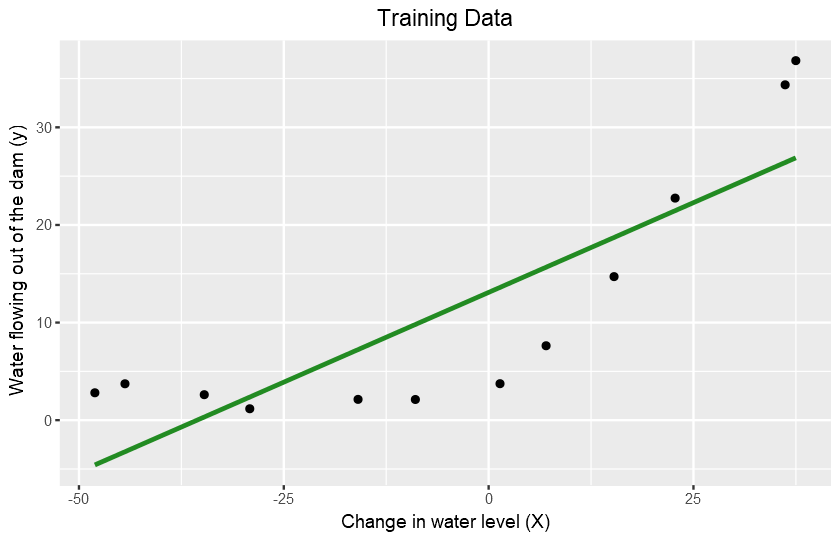

In [7]:
# Generating predictions
df <- df %>% mutate(Prediction = optimalTheta[1] + .$X * optimalTheta[2])

ggplot(df) +
  geom_point(aes(X, y)) +
  geom_line(aes(X, Prediction), color='forestgreen', size=1) +
  labs(x="Change in water level (X)",
       y="Water flowing out of the dam (y)",
       title="Training Data")

---

##  *Part II:* Bias-Variance

The [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) is a ubiquitous problem in machine learning for getting models to generalize beyond their training set.  At its core, it is a way to see if a model is over or underfitting, and it is a diagnostic that can help determine how to improve the model (e.x. gather more samples, gather other features, remove features, etc.).  Here are the definitions on bias and variance

- **Bias:**  Error from erroneous assumptions in the learning algorithm.  High bias can cause an algorithm to miss the relevant relations between features and target outputs (*underfitting*)

- **Variance:** Error from sensitivity to small fluctuations in the training set.  High variance can cause *overfitting*: modeling the random noise in the training data, rather than the intended outputs

If you're a visual learner like myself, here's a common visualization to describe bias and variance:

<img src="http://www.kdnuggets.com/wp-content/uploads/bias-and-variance.jpg" style="width: 350px">

To reiterate, a high bias leads to overfitting, and a high variance leads to underfitting.  Trying to minimize both tends to result in a good generalized fit that will perform well on data that the model hasn't seen before.

[This blog post](http://scott.fortmann-roe.com/docs/BiasVariance.html) also does an exceptional job at explaining the bias-variance tradeoff in further detail.

### Learning curves

Learning curves are an excellent way to show the bias and variance of our model.  They are a graph of the error of both the validation set and the training set by the number of training examples.  The shape of these errors will help us deduce the bias/variance of the model.  Here are examples showing the cases of high/low bias/variance (note: this is a transposed version of the targets shown above):

<img src="http://www.ultravioletanalytics.com/wp-content/uploads/2014/12/bias_variance_chart1.jpg"style="width: 450px">

For reference, here are the cost functions to be used in the learning curves.  Note that the cost in the training set only applies to the records that it has seen up until that point, but the cost on the validation set applies to the entire validation set:

$$J_{train}(\theta) = \frac{1}{2m} \big[ \sum_{i=1}^m (h_{\theta}(x^{(o)})-y^{(i)})^2 \big]$$

$$J_{validation}(\theta) = \frac{1}{2m_{validation}} \big[ \sum_{i=1}^{m_{validation}} (h_{\theta}(x_{validation}^{(o)})-y_{validation}^{(i)})^2 \big]$$

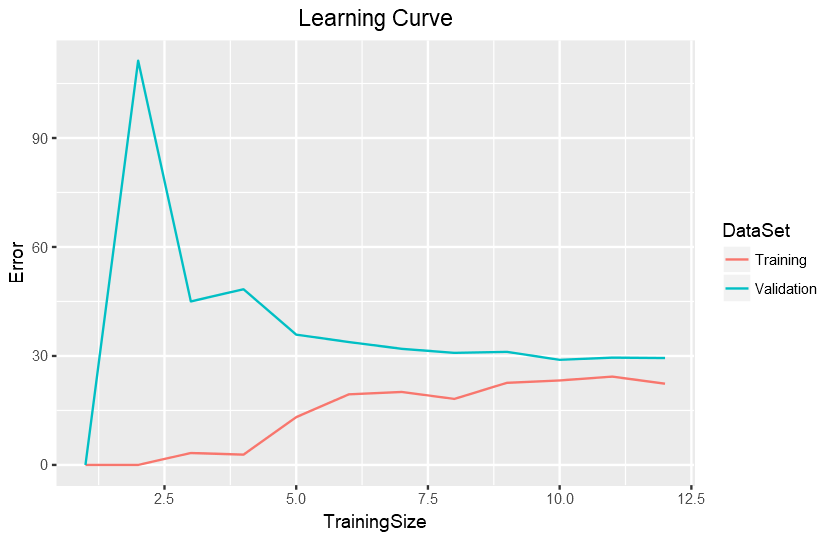

In [8]:
plot_learning_curve <- function(Xtrain, ytrain, Xval, yval, C=0.0) {
  # Plots the learning curve of the regularized logistic regression
  m <- length(ytrain)
  
  # Creating empty arrays to add the error to
  trainingError <- numeric(m)
  validationError <- numeric(m)
  
  # Looping through training sizes to calculate our errors
  for (i in 2:m) {
    
    # Optimizing theta with the given training size
    initialThetas <- numeric(dim(Xtrain)[2]+1)
    thetas <- fit_model(initialThetas, Xtrain[1:i], ytrain[1:i], C)
    
    # Calculating the training error
    trainingError[i] <- cost_function(thetas, Xtrain[1:i], ytrain[1:i],
                                      0)  # Excluding reg parameter
    
    # Calculating the training error
    validationError[i] <- cost_function(thetas, Xval, yval,
                                      0)  # Excluding reg parameter
  }
  
  # Storing the training error in a data frame
  results <- data.frame(Error = trainingError, DataSet = 'Training',
                        TrainingSize = 1:m)
  
  # Storing the validation error into a data frame
  validation <- data.frame(Error = validationError, DataSet = 'Validation',
                           TrainingSize = 1:m)
  
  # Joing the two into one data frame
  results <- rbind(results, validation)
  
  # Plotting the data
  learning_curve <- ggplot(results) +
    geom_line(aes(x=TrainingSize, y=Error, color=DataSet)) + 
    labs(title="Learning Curve")
  
  return(learning_curve)
}


plot_learning_curve(X, y, Xval, yval)

This model is suffering from high bias, which we could have inferred from plotting the fitting curve in the first section

---

##  *Part III:* Polynomial Regression

Since our initial fit had a very high bias, we'll introduce polynomial terms to obtain a better fit that reduces the bias

We also have to normalize our features when introducing the polynomial terms, which we'll do with standard scaling.  This results in each column having a mean of 0 and a standard deviation of 1.  As a reminder, the formula is $$x' = \frac{x - \bar{x}}{\sigma}$$

For simplicity's sake, we'll use R's built in *scale* function to do this

In [9]:
map_polynomial <- function(X, order) {
  # Maps X up to the polynomial order specified
  # Xpoly <- matrix(X)
  Xpoly <- as.matrix(X)
  
  if (order <= 1) {
    return(X)
  }
  
  for (i in 2:order) {
    Xpoly <- cbind(Xpoly, X^i)
  }
  
  return(Xpoly)
}


preprocess_features <- function(Xtrain, Xval, Xtest, order=1) {
  # A convenience function that performs the previous two functions

  # Mapping the polynomial terms
  Xtrain <- map_polynomial(Xtrain, order)
  Xval <- map_polynomial(Xval, order)
  Xtest <- map_polynomial(Xtest, order)
  
  return(list("Training" = scale(Xtrain),
              "Validation" = scale(Xval),
              "Testing" = scale(Xtest)))
}


# Checking that map_polynomial is outputting the right number of columns
power <- 6
cat('Polynomial size:', dim(map_polynomial(X, power)), '\n')

# Checking that the mean of each column in X is 0
colMeans(preprocess_features(X, Xval, Xtest, 4)$Training)

Polynomial size: 12 6 


[1] -4.625929e-18 -9.569891e-17  2.544261e-17 -4.047688e-17

### Fitting

We'll try polynomial terms up until the order of 4 and see what the fit looks like

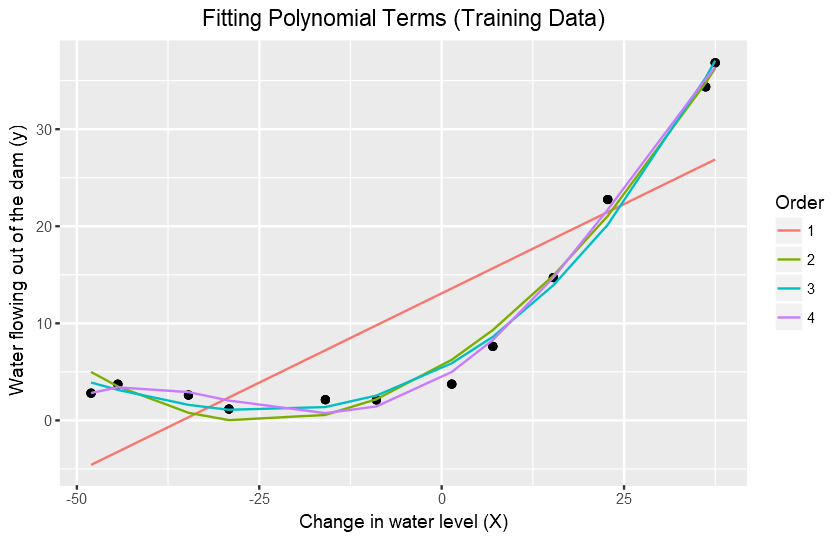

In [10]:
polynomial_orders <- 4

# Copying the data frame to be filled for the plot
dfPoly <- df %>% mutate(Order = 1)

# Generating predictions for the orders specified
for (order in 2:polynomial_orders) {
  Xpoly <- preprocess_features(X, Xval, Xtest, order)$Training
  optimalTheta <- fit_model(numeric(order+1), Xpoly, y)
  prediction <- optimalTheta[1] + rowSums(t(t(Xpoly) * optimalTheta[-1]))
  dfPoly <- rbind(dfPoly, 
                  data.frame(X, y, Prediction=prediction, Order=order))
}

# Adjusting the order as a factor for ggplot
dfPoly$Order <- as.factor(dfPoly$Order)

# Plotting the data
ggplot(dfPoly) + 
  geom_point(aes(X, y)) + 
  geom_line(aes(X, Prediction, color=Order)) +
  labs(x="Change in water level (X)",
       y="Water flowing out of the dam (y)",
       title="Fitting Polynomial Terms (Training Data)")

Plotting the learning curve of the second order polynomials:

In [11]:
polynomial_orders <- 2

# Plotting the learning curve
preprocessed_features <- preprocess_features(X, Xval, Xtest, order=polynomial_orders)

plot_learning_curve(preprocessed_features$Training, y,
                    preprocessed_features$Validation, yval)

The gap between the training error and the validation error indicates a high variance problem, which can potentially be solved with regularization

### Adjusting the regularization parameter

We're going to look at the fitting lines of a few different values of lambda, and review the learning curve to see if the variance problem is fixed 

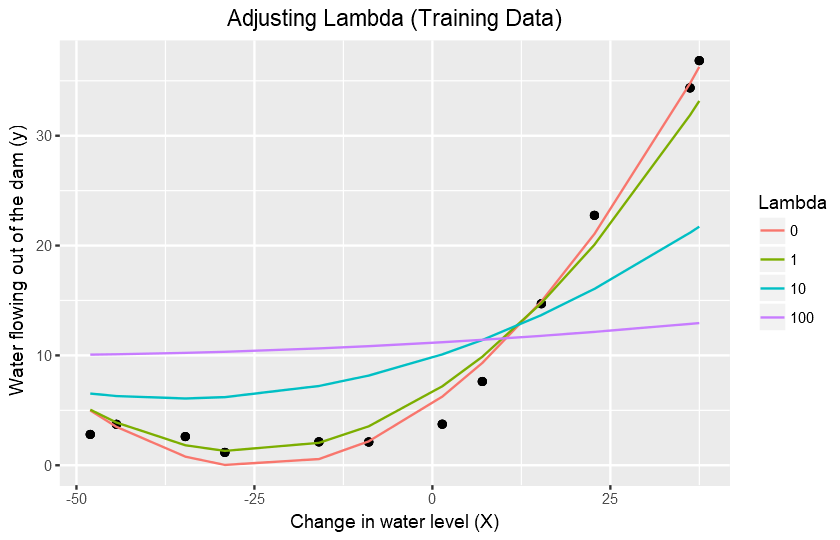

In [12]:
polynomial_orders <- 2

# Copying the data frame to be filled for the plot
dfReg <- df %>% mutate(Lambda = -1)  # Flagging to be dropped

# Generating the polynomial features for the training set
Xpoly <- preprocess_features(X, Xval, Xtest, order=polynomial_orders)$Training

# Looping through different values of lambda
for (C in c(0, 1, 10, 100)) {
  optimalTheta <- fit_model(numeric(polynomial_orders+1), Xpoly, y, C)
  prediction <- optimalTheta[1] + rowSums(t(t(Xpoly) * optimalTheta[-1]))
  dfReg <- rbind(dfReg, 
                  data.frame(X, y, Prediction=prediction, Lambda=C))
}

# Adjusting the order as a factor for ggplot
dfReg$Lambda <- as.factor(dfReg$Lambda)

# Removing the non polynomial predictions
dfReg <- dfReg %>% filter(Lambda != -1)

# Plotting the data
ggplot(dfReg) + 
  geom_point(aes(X, y)) + 
  geom_line(aes(X, Prediction, color=Lambda)) +
  labs(x="Change in water level (X)",
       y="Water flowing out of the dam (y)",
       title="Adjusting Lambda (Training Data)")

There's now a wider gap between the two which indicates that our variance has lowered

### Selecting $\lambda$ using a cross validation set

Here we will evaluate the error on our $\lambda$ values by plotting a validation curve.  This is a way to evaluate error as a function of model complexity.

According to the validation curve, a $\lambda \in [2,3]$ are the optimal choices